In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import json

In [2]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
RGB_IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

TRAIN_IMAGE_PATH = '/home/ilambda/goods_viewer/Debasish/dataset/1_train_split/whole_resize'
TEST_IMAGE_PATH = '/home/ilambda/goods_viewer/Debasish/dataset/1_eval_img_resize/'

BASE_MODEL_NAME = 'ecom-image-model_basemodel_2020_02_20_20_25_21.h5'

In [3]:
import tensorflow as tf
keras = tf.keras

In [4]:
def read_list_from_disk(filename, directory="."):
    plist = []
    if not os.path.exists(filename):
        print(f"File path not found: {filename}\n List could not be retrieved")
    with open(filename, 'r') as filehandle:
        for line in filehandle:
            # remove linebreak which is the last character of the string
            l = line[:-1]
            plist.append(l)

    return plist

def read_history(filename):
    history = open(filename).read()
    history = dict(eval(json.loads(history), {"array": np.array, "float32": float}))
    return history

In [5]:
label_columns = read_list_from_disk('filtered_features.txt')

In [6]:
training_df = pd.read_csv('attributes_training_df.csv', index_col='index')
testing_df = pd.read_csv('attributes_testing_df.csv', index_col='index')

features = read_list_from_disk('filtered_features.txt')

print(f"Training shape: {training_df.shape}")
print(f"Testing shape: {testing_df.shape}")
print(f"Features length: {len(features)}")

Training shape: (96197, 232)
Testing shape: (11453, 232)
Features length: 112


In [7]:
data_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, preprocessing_function=keras.applications.resnet50.preprocess_input)

test_gen = data_gen.flow_from_dataframe(testing_df,directory=TEST_IMAGE_PATH, batch_size=32, shuffle=False,
                                        x_col='filename', y_col=label_columns, class_mode='other', 
                                        target_size=IMAGE_SIZE)

Found 11453 validated image filenames.


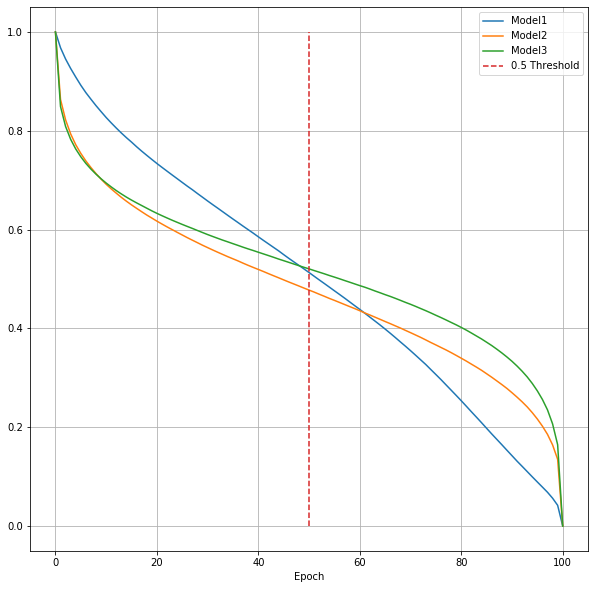

In [84]:
plt.figure(figsize=(10,10))
plt.plot(history1['val_recall'][-1], label="Model1")
plt.plot(history2['val_recall'][-1], label="Model2")
plt.plot(history3['val_recall'][-1], label="Model3")
#plt.plot(history3['val_recall'][-1], label="recall")
plt.plot([50,50], [0,1], linestyle='--', label="0.5 Threshold")
plt.grid()
plt.xlabel("Epoch")
plt.legend()
plt.show()

#plt.figure(figsize=(32,32))
fig, axes = plt.subplots(2,1, sharex=True, sharey=True)
fig.set_figheight(12)
for i, recall in enumerate(history5['val_recall']):
    axes[0].plot(recall, marker='.', label="Val_Epoch "+str(i+1))
axes[0].set_title("Validation Precision")
axes[0].grid()

axes[0].set_xticks(x_ticks, x_ticks_labels)
for i, precision in enumerate(history5['val_precision']):
    axes[1].plot(precision, marker='.', label="Val_Epoch "+str(i+1))
axes[1].set_title("Validation Recall")
axes[1].grid()
fig.show()

In [17]:
x_ticks_labels = [float(i/100) for i in range(0,101,10)]
x_ticks = [i for i in range(0,101,10)]

def plot_train_vs_test(metric_dict, xticks=[0,5,10,15,20]):
    plt.figure(figsize=(10,10))
    for key in metric_dict.keys():
        plt.plot(metric_dict[key], label=key)
    plt.grid()
    plt.xlabel("Epoch")
    plt.xticks(xticks,labels=xticks)
    plt.legend()
    plt.show()
    
def compare_models(models_dict, metric_name, xticks=[0,5,10,15,20]):
    plt.figure(figsize=(10,10))
    for key in models_dict.keys():
        plt.plot(models_dict[key], label=key)
    plt.grid()
    plt.xlabel("Epoch")
    plt.xticks(xticks,labels=xticks)
    plt.legend()
    plt.title(f"Comparison of {metric_name}")
    plt.show()
    
def compare_precision_recall_curves(models_dict, metric_name):
    x_ticks_labels = [float(i/100) for i in range(0,101,10)]
    x_ticks = [i for i in range(0,101,10)]
    plt.figure(figsize=(10,10))
    for key in models_dict.keys():
        plt.plot(models_dict[key], marker='.', label=key)
    
    plt.legend()
    plt.grid()
    plt.xticks(x_ticks, x_ticks_labels)
    plt.xlabel("Threshold")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} comparison for different models")
    plt.show()

### Comparison of different Models
- Model with only dense layer trained. Base resnet model is all frozen
- Model with class weights and dense only layer trained.
- Model with all layers trainable

In [8]:
history_dense_only_1 = open('new_filt_attribs_prep_4_history_2020_03_02_11_32_12.json').read()
history_dense_only_1 = dict(eval(json.loads(history_dense_only_1), {"array": np.array, "float32": float}))
history_dense_only_2 = open('new_filt_attribs_prep_4.1_history_2020_03_02_19_02_15.json').read()
history_dense_only_2 = dict(eval(json.loads(history_dense_only_2), {"array": np.array, "float32": float}))
history_dense_only = {}
for key in history_dense_only_1.keys():
    history_dense_only[key] = history_dense_only_1[key] + history_dense_only_2[key]

In [56]:
def plot_metrics_for_models(history_list, model_names, metric_name, color_list=['blue','orange','green','yellow','purple','pink', 'red']):
    """
    Plots the corresponding training and validation data for the metric_name provided for the list of models
    and their corresponding history provided in form of list
    :param history_list: list of history dictionary object for models
    :param model_names: list of model names
    :color_list: list of colors to use for different models (default colors: ['blue','orange','green','yellow','purple','pink', 'red'])
    :return: Plots a line plot with training attributes as solid line and validation attributes as dotted lines
    """

    plt.figure(figsize=(10,10))
    epochs = len(history_list[0]['loss'])
    xticks = [i for i in range(0, int(epochs)+1, 2)]
    for i, history in enumerate(history_list):
        #for metric_name in metric_list:
            #metric_name = metric_list[i]
        val_metric_name = "val_"+metric_name
        color = color_list[i]
        plt.plot(history[metric_name], label=model_names[i]+"_"+metric_name, color=color)
        plt.plot(history[val_metric_name], label=model_names[i]+"_"+val_metric_name, linestyle='--', color=color)
    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.xticks(xticks,labels=xticks)
    plt.title(f"Training and Validation {metric_name} for different models")
    plt.legend()
    plt.show()

In [24]:
history_cw_1 = open('new_filt_attribs_prep_cw_4_history_2020_03_02_13_37_50.json').read()
history_cw_1 = dict(eval(json.loads(history_cw_1), {"array": np.array, "float32": float}))
history_cw_2 = open('new_filt_attribs_prep_cw_4.1_history_2020_03_02_17_32_58.json').read()
history_cw_2 = dict(eval(json.loads(history_cw_2), {"array": np.array, "float32": float}))
history_cw = {}
for key in history_cw_1.keys():
    history_cw[key] = history_cw_1[key] + history_cw_2[key]

In [25]:
history_base_train = open('new_filt_attribs_base_train_history_2020_03_03_02_37_33.json').read()
history_base_train = dict(eval(json.loads(history_base_train), {"array": np.array, "float32": float}))

#### The below two models are added later

In [61]:
history_all_layers_2 = open('new_filt_attribs_all_layers_e_20_history_2020_03_03_20_03_57.json').read()
history_all_layers_2 = dict(eval(json.loads(history_all_layers_2), {"array": np.array, "float32": float}))

history_all_layers_cw = open('new_filt_attribs_all_layers_cw_e_20_history_2020_03_04_04_56_34.json').read()
history_all_layers_cw = dict(eval(json.loads(history_all_layers_cw), {"array": np.array, "float32": float}))

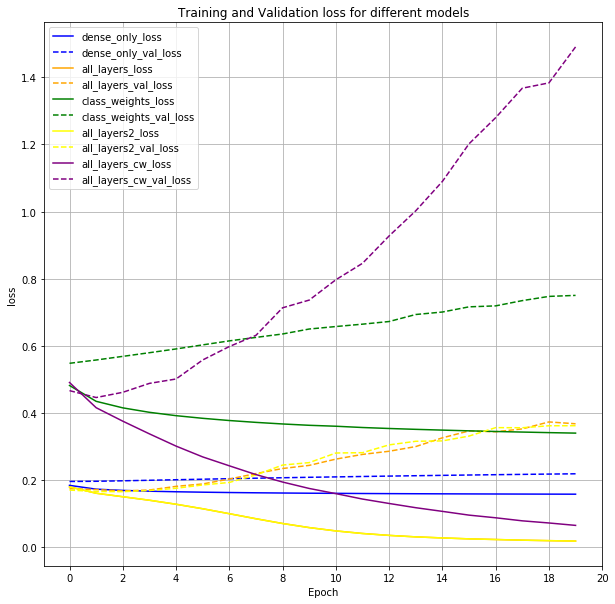

In [65]:
plot_metrics_for_models([history_dense_only, history_base_train, history_cw, history_all_layers_2, history_all_layers_cw], ['dense_only', 'all_layers', 'class_weights', 'all_layers2', 'all_layers_cw'],metric_name='loss')

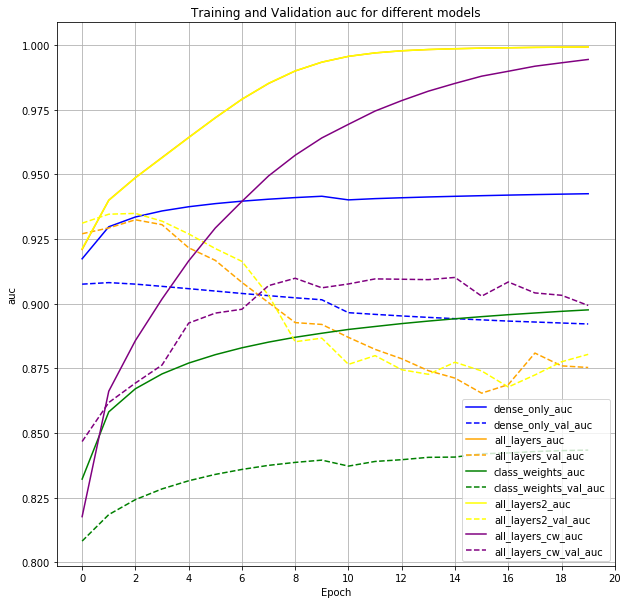

In [76]:
plot_metrics_for_models([history_dense_only, history_base_train, history_cw, history_all_layers_2, history_all_layers_cw], ['dense_only', 'all_layers', 'class_weights', 'all_layers2', 'all_layers_cw'],metric_name='auc')

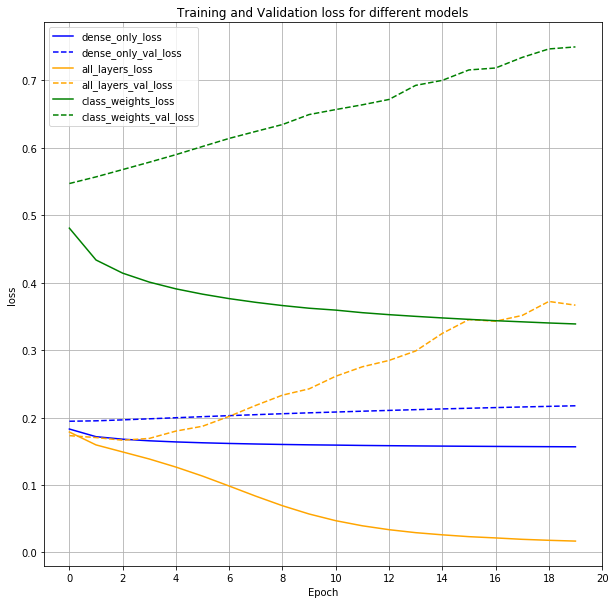

In [62]:
plot_metrics_for_models([history_dense_only, history_base_train, history_cw], ['dense_only', 'all_layers', 'class_weights'],metric_name='loss')

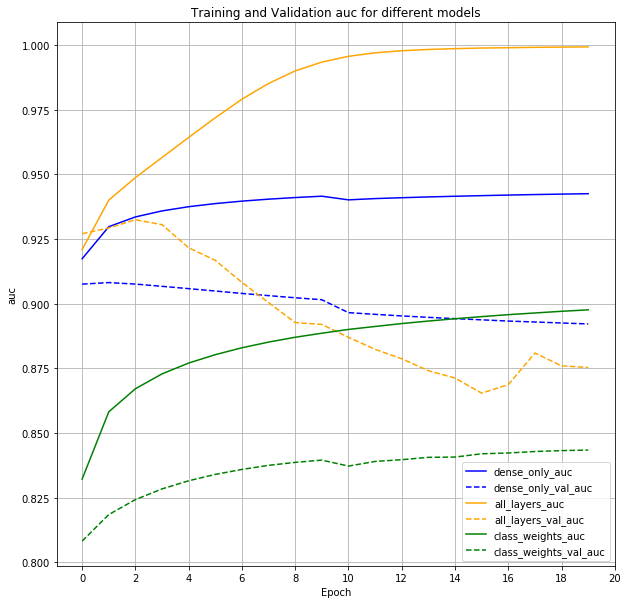

In [58]:
plot_metrics_for_models([history_dense_only, history_base_train, history_cw], ['dense_only', 'all_layers', 'class_weights'],metric_name='auc')

### Comparison of Precision Recall for different models

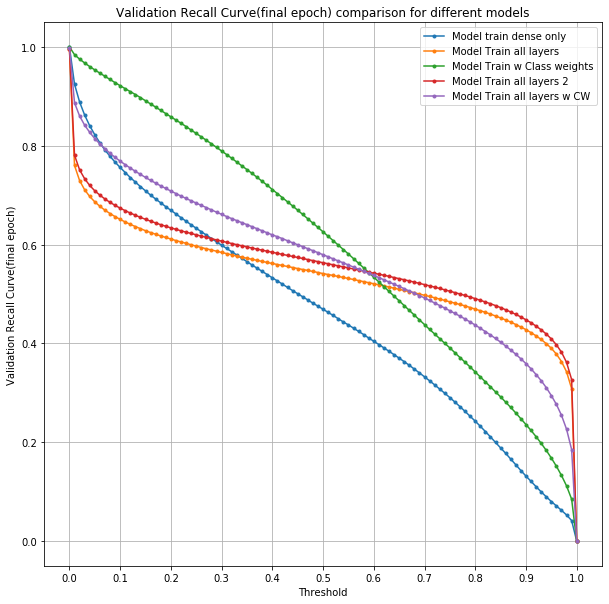

In [87]:
metric_name = "val_recall"
val_recall_dict = {"Model train dense only": history_dense_only[metric_name][-1], 
                   "Model Train all layers": history_base_train[metric_name][-1], 
                   "Model Train w Class weights": history_cw[metric_name][-1], 
                   "Model Train all layers 2": history_all_layers_2[metric_name][-1], 
                   "Model Train all layers w CW": history_all_layers_cw[metric_name][-1]}

compare_precision_recall_curves(val_recall_dict, "Validation Recall Curve(final epoch)")

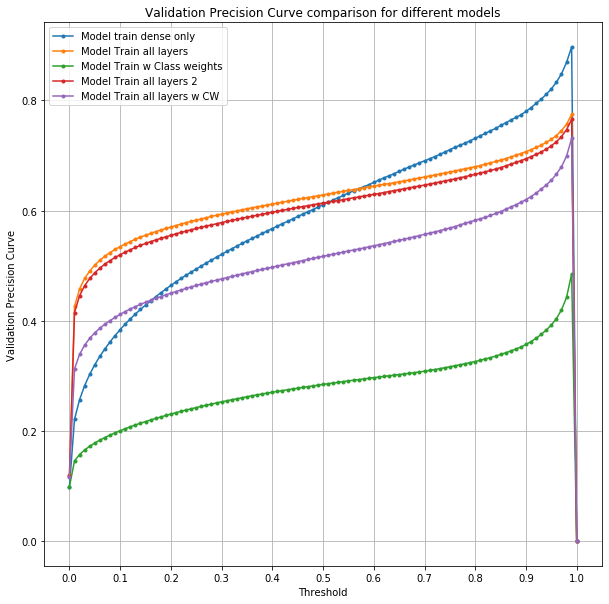

In [88]:
metric_name = "val_precision"
val_recall_dict = {"Model train dense only": history_dense_only[metric_name][-1], 
                   "Model Train all layers": history_base_train[metric_name][-1], 
                   "Model Train w Class weights": history_cw[metric_name][-1], 
                   "Model Train all layers 2": history_all_layers_2[metric_name][-1], 
                   "Model Train all layers w CW": history_all_layers_cw[metric_name][-1]}

compare_precision_recall_curves(val_recall_dict, "Validation Precision Curve")

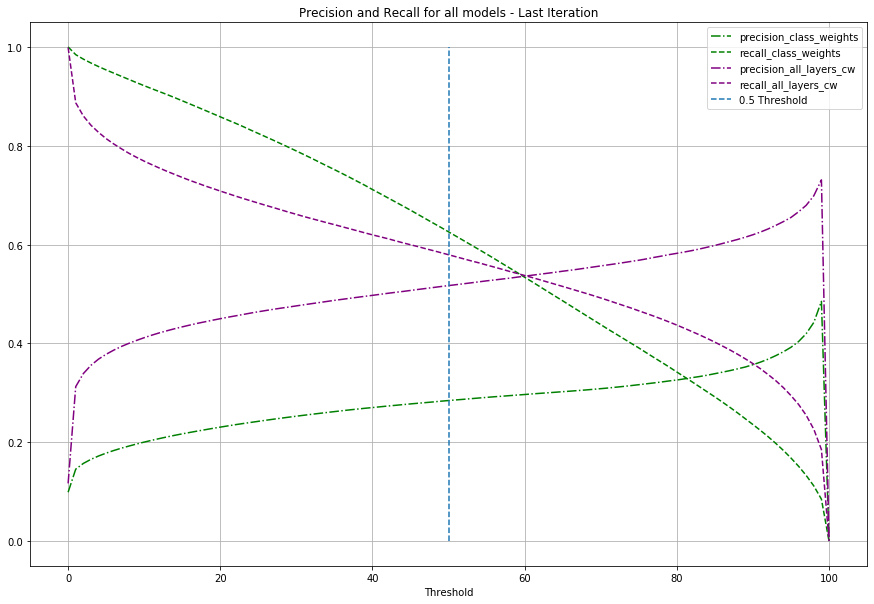

In [91]:
plt.figure(figsize=(15,10))
#plt.plot(history_dense_only['val_precision'][-1], label="precision_dense_only", color="blue", linestyle='-.')
#plt.plot(history_dense_only['val_recall'][-1], label="recall_dense_only", color="blue", linestyle='--')
#plt.plot(history_base_train['val_precision'][-1], label="precision_all_layers", color="orange", linestyle='-.')
#plt.plot(history_base_train['val_recall'][-1], label="recall_all_layers", color="orange", linestyle='--')
plt.plot(history_cw['val_precision'][-1], label="precision_class_weights", color="green", linestyle='-.')
plt.plot(history_cw['val_recall'][-1], label="recall_class_weights", color="green", linestyle='--')
#plt.plot(history_all_layers_2['val_precision'][-1], label="precision_all_layers_2", color="red", linestyle='-.')
#plt.plot(history_all_layers_2['val_recall'][-1], label="recall_all_layers_2", color="red", linestyle='--')
plt.plot(history_all_layers_cw['val_precision'][-1], label="precision_all_layers_cw", color="purple", linestyle='-.')
plt.plot(history_all_layers_cw['val_recall'][-1], label="recall_all_layers_cw", color="purple", linestyle='--')
plt.plot([50,50], [0,1], linestyle='--', label="0.5 Threshold")
plt.grid()
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision and Recall for all models - Last Iteration")
plt.show()

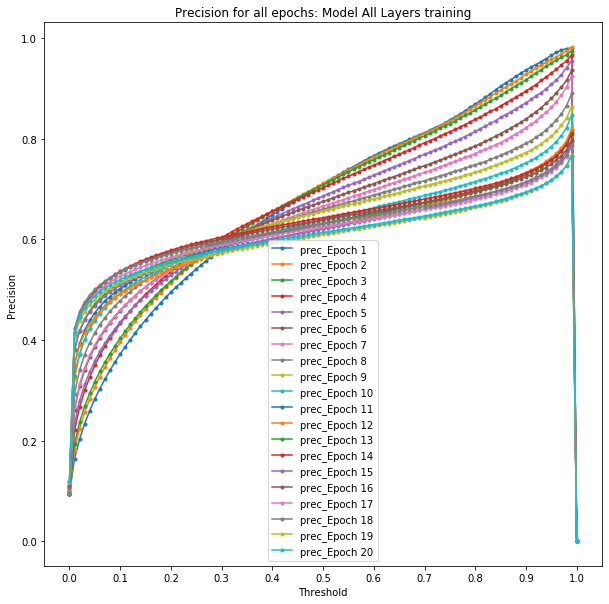

In [92]:
x_ticks_labels = [float(i/100) for i in range(0,101,10)]
x_ticks = [i for i in range(0,101,10)]
plt.figure(figsize=(10,10))
for i, recall in enumerate(history_all_layers_2['val_precision']):
    plt.plot(recall, marker='.', label="prec_Epoch "+str(i+1))

plt.legend()
plt.xticks(x_ticks, x_ticks_labels)
plt.xlabel("Threshold")
plt.ylabel("Precision")
plt.title("Precision for all epochs: Model All Layers training")
plt.show()

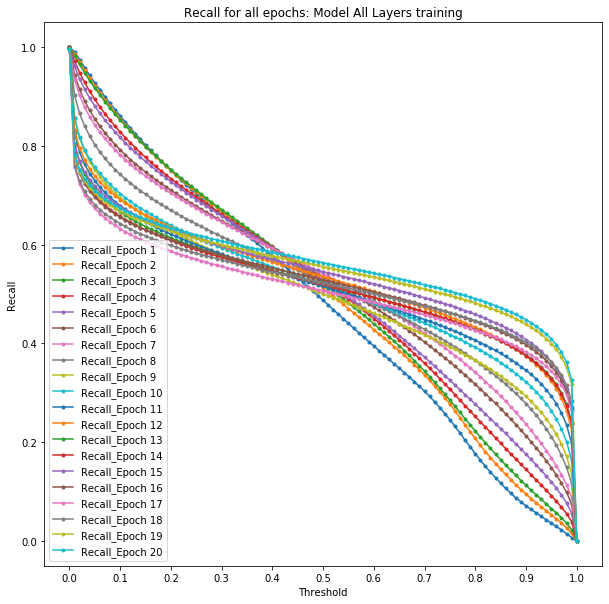

In [93]:
x_ticks_labels = [float(i/100) for i in range(0,101,10)]
x_ticks = [i for i in range(0,101,10)]
plt.figure(figsize=(10,10))
for i, recall in enumerate(history_all_layers_2['val_recall']):
    plt.plot(recall, marker='.', label="Recall_Epoch "+str(i+1))

plt.legend()
plt.xticks(x_ticks, x_ticks_labels)
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Recall for all epochs: Model All Layers training")
plt.show()

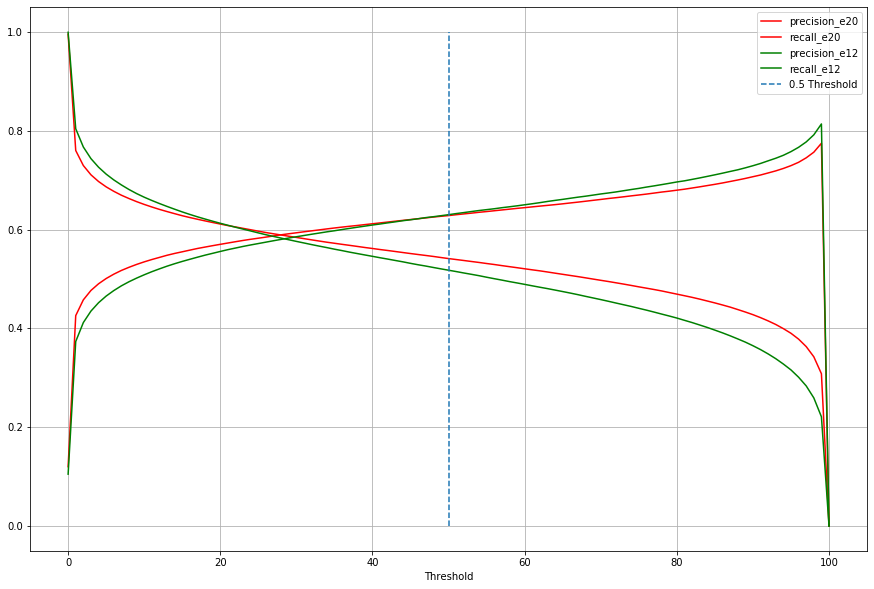

In [325]:
plt.figure(figsize=(15,10))
#plt.plot(history_dense_only['val_precision'][-1], label="precision_dense_only", color="blue")
#plt.plot(history_dense_only['val_recall'][-1], label="recall_dense_only", color="blue")
plt.plot(history_base_train['val_precision'][-1], label="precision_e20", color="red")
plt.plot(history_base_train['val_recall'][-1], label="recall_e20", color="red")
plt.plot(history_base_train['val_precision'][13], label="precision_e12", color="green")
plt.plot(history_base_train['val_recall'][13], label="recall_e12", color="green")
plt.plot([50,50], [0,1], linestyle='--', label="0.5 Threshold")
plt.grid()
plt.xlabel("Threshold")
plt.legend()
plt.show()

### Load all the models

In [228]:
model_dense_only = keras.models.load_model('new_filt_attribs_prep_4.1_model_2020_03_02_19_02_15.h5')

In [229]:
model_all_layers = keras.models.load_model('new_filt_attribs_base_train_model_2020_03_03_02_37_32.h5')

#### Model with class weights

In [237]:
model_class_weights = keras.models.load_model('new_filt_attribs_prep_cw_4.1_model_2020_03_02_17_32_58.h5', compile=False)

#### Below 2 models are developed later

In [66]:
model_all_layers_2 = keras.models.load_model('new_filt_attribs_all_layers_e_20_model_2020_03_03_20_03_56.h5')

In [67]:
model_all_layers_cw_temp = keras.models.load_model('new_filt_attribs_all_layers_cw_e_20_model_2020_03_04_04_56_33.h5', compile=False)

In [72]:
model_all_layers_cw = create_model_with_cw(class_weights)

In [73]:
model_all_layers_cw.set_weights(model_all_layers_cw_temp.get_weights())

In [132]:
import importlib
import class_weights_utils as cwutils
importlib.reload(cwutils)

<module 'class_weights_utils' from '/home/ilambda/goods_viewer/Debasish/class_weights_utils.py'>

In [68]:
class_weights = cwutils.calculate_class_weights(training_df, features)
np.save(f"class_weights_{len(features)}", class_weights)

def create_model_with_cw(class_weights, lr = 0.0001): 
    lr = 0.0001
    thresholds = [float(i/100) for i in range(0, 101)]

    # metrics
    tp = keras.metrics.TruePositives(thresholds=thresholds, name="tp")
    tn = keras.metrics.TrueNegatives(thresholds=thresholds, name="tn")
    fp = keras.metrics.FalsePositives(thresholds=thresholds, name="fp")
    fn = keras.metrics.FalseNegatives(thresholds=thresholds, name="fn")
    precision = keras.metrics.Precision(thresholds=thresholds, name='precision')
    recall = keras.metrics.Recall(thresholds=thresholds, name='recall')
    auc = keras.metrics.AUC(name="auc", thresholds=thresholds)

    # Optimizer
    adam = keras.optimizers.Adam(learning_rate=lr)

    # Loss function
    custom_loss = cwutils.get_weighted_loss(class_weights)

    # Base model
    base_model = keras.models.load_model(BASE_MODEL_NAME)
    base_model.trainable = False

    model_cw = keras.models.Sequential()
    model_cw.add(base_model)
    model_cw.add(keras.layers.Dense(len(features), activation="sigmoid"))

    model_cw.compile(optimizer=adam,
                  loss=custom_loss,
                  metrics=['accuracy', tp, tn, fp, fn, precision, recall, auc])
    return model_cw

In [254]:
model_cw.set_weights(model_class_weights.get_weights())

#### Evaluation results of all models

In [235]:
test_gen.reset()
results_eval_model_dense_only = model_dense_only.evaluate(test_gen)

358/358 [==============================] - 49s 136ms/step - loss: 0.2633 - accuracy: 0.9061 - tp: 55028.2578 - tn: 1073745.8750 - fp: 72089.0781 - fn: 81872.7422 - precision: 0.5675 - recall: 0.4020 - auc: 0.8724


In [236]:
test_gen.reset()
results_eval_model_all_layers = model_all_layers.evaluate(test_gen)

358/358 [==============================] - 48s 134ms/step - loss: 0.4400 - accuracy: 0.9152 - tp: 68130.5234 - tn: 1094056.3750 - fp: 51778.6523 - fn: 68770.4766 - precision: 0.6149 - recall: 0.4977 - auc: 0.8570


In [255]:
test_gen.reset()
results_eval_model_cw = model_cw.evaluate(test_gen)

358/358 [==============================] - 60s 168ms/step - loss: 0.8938 - accuracy: 0.0287 - tp: 76650.5781 - tn: 909676.7500 - fp: 236158.2969 - fn: 60250.4258 - precision: 0.2740 - recall: 0.5599 - auc: 0.8180


In [74]:
test_gen.reset()
results_eval_model_all_layers_2 = model_all_layers_2.evaluate(test_gen)

358/358 [==============================] - 50s 140ms/step - loss: 0.4291 - accuracy: 0.9142 - tp: 71432.2969 - tn: 1089176.3750 - fp: 56658.5430 - fn: 65468.7031 - precision: 0.6016 - recall: 0.5218 - auc: 0.8637


In [75]:
test_gen.reset()
results_eval_model_all_layers_cw = model_all_layers_cw.evaluate(test_gen)

358/358 [==============================] - 49s 136ms/step - loss: 1.8134 - accuracy: 0.0798 - tp: 73276.0234 - tn: 1061836.8750 - fp: 83998.1406 - fn: 63624.9805 - precision: 0.5123 - recall: 0.5352 - auc: 0.8839


In [108]:
import classification_utils as classiutils
importlib.reload(classiutils)

<module 'classification_utils' from '/home/ilambda/goods_viewer/Debasish/classification_utils.py'>

In [256]:
test_gen.reset()
preds_dense_only = model_dense_only.predict(test_gen)
test_gen.reset()
preds_all_layers = model_all_layers.predict(test_gen)
test_gen.reset()
preds_cw = model_cw.predict(test_gen)

In [77]:
test_gen.reset()
preds_all_layers_2 = model_all_layers_2.predict(test_gen)
test_gen.reset()
preds_all_layers_cw = model_all_layers_cw.predict(test_gen)

In [85]:
actuals = test_gen.labels

#### Save the predictions as .npy

In [335]:
np.save('preds_dense_only.npy', preds_dense_only)
np.save('preds_all_layers.npy', preds_all_layers)
np.save('preds_cw.npy', preds_cw)

In [80]:
np.save('preds_all_layers_2.npy', preds_all_layers_2)
np.save('preds_all_layers_cw.npy', preds_all_layers_cw)

#### Load the predictions

In [79]:
preds_all_layers = np.load('preds_all_layers.npy')
preds_dense_only = np.load('preds_dense_only.npy')
preds_cw = np.load('preds_cw.npy')

In [113]:
history_all_layers_2['loss']

[0.1783321733917345,
 0.15961843356633973,
 0.14912369560927524,
 0.13871766925597198,
 0.1268243053132207,
 0.11325316299139726,
 0.09848305672356697,
 0.08335660011049364,
 0.06916500578923693,
 0.05696226926724882,
 0.04708722107576672,
 0.039380991826276884,
 0.03376164717957187,
 0.029345914946042002,
 0.026245326221937672,
 0.023462491329264666,
 0.02138404209587657,
 0.01960696401141745,
 0.018193208848063802,
 0.0168044183273675]

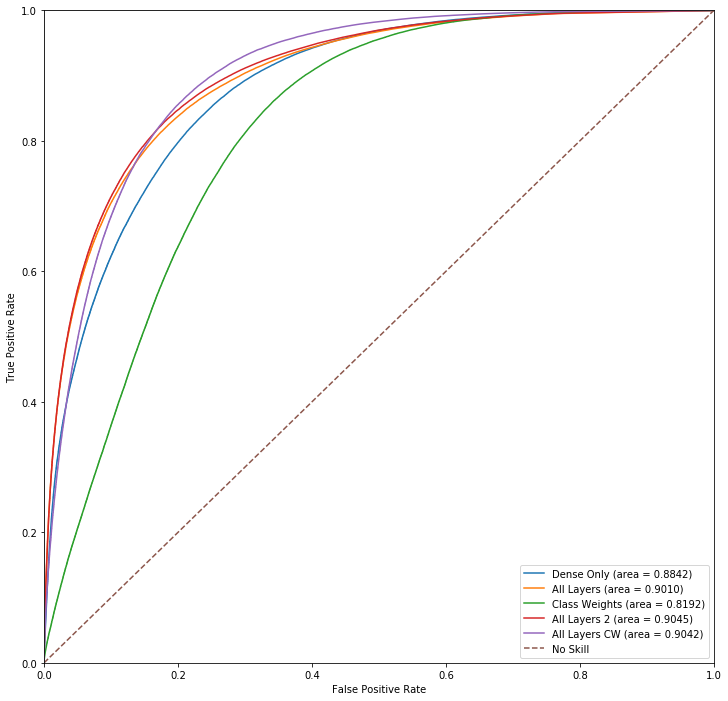

In [109]:
classiutils.roc_comparison([preds_dense_only, preds_all_layers, preds_cw, preds_all_layers_2, preds_all_layers_cw], actuals, model_names=['Dense Only', 'All Layers', 'Class Weights', 'All Layers 2', 'All Layers CW'])

In [94]:
classifications_dense_only = classiutils.result_classifications(actuals, preds_dense_only)
classifications_all_layers = classiutils.result_classifications(actuals, preds_all_layers)
classifications_preds_cw = classiutils.result_classifications(actuals, preds_cw)
classifications_all_layers_2 = classiutils.result_classifications(actuals, preds_all_layers_2)
classifications_all_layers_cw = classiutils.result_classifications(actuals, preds_all_layers_cw)

In [326]:
classifications_all_layers_30 = classiutils.result_classifications(actuals, preds_all_layers, threshold=0.3)
presrecalls_alllayers_30 = classiutils.calculate_pres_recall(actuals, preds_all_layers, classifications_all_layers_30, threshold=0.3)

In [95]:
presrecalls_denseonly = classiutils.calculate_pres_recall(actuals, preds_dense_only, classifications_dense_only)
presrecalls_alllayers = classiutils.calculate_pres_recall(actuals, preds_all_layers, classifications_all_layers)
presrecalls_classweights = classiutils.calculate_pres_recall(actuals, preds_cw, classifications_preds_cw)
presrecalls_alllayers_2 = classiutils.calculate_pres_recall(actuals, preds_all_layers_2, classifications_all_layers_2)
presrecalls_alllayers_cw = classiutils.calculate_pres_recall(actuals, preds_all_layers_cw, classifications_all_layers_cw)

In [96]:
f1_denseonly = dict(list(map(lambda x: (x[0],classiutils.calculate_f1score(x[1][0], x[1][1])), presrecalls_denseonly.items())))
f1_alllayers = dict(list(map(lambda x: (x[0],classiutils.calculate_f1score(x[1][0], x[1][1])), presrecalls_alllayers.items())))
f1_classweights = dict(list(map(lambda x: (x[0],classiutils.calculate_f1score(x[1][0], x[1][1])), presrecalls_classweights.items())))
f1_alllayers_2 = dict(list(map(lambda x: (x[0],classiutils.calculate_f1score(x[1][0], x[1][1])), presrecalls_alllayers_2.items())))
f1_alllayers_cw = dict(list(map(lambda x: (x[0],classiutils.calculate_f1score(x[1][0], x[1][1])), presrecalls_alllayers_cw.items())))

In [97]:
f1_df = pd.DataFrame({"name": features, 
                      "denseonly": list(f1_denseonly.values()), 
                      "alllayers": list(f1_alllayers.values()), 
                      "classweights": list(f1_classweights.values()), 
                      "alllayers_2": list(f1_alllayers_2.values()), 
                      "alllayers_cw": list(f1_alllayers_cw.values())})

In [98]:
f1_df.set_index('name', inplace=True)

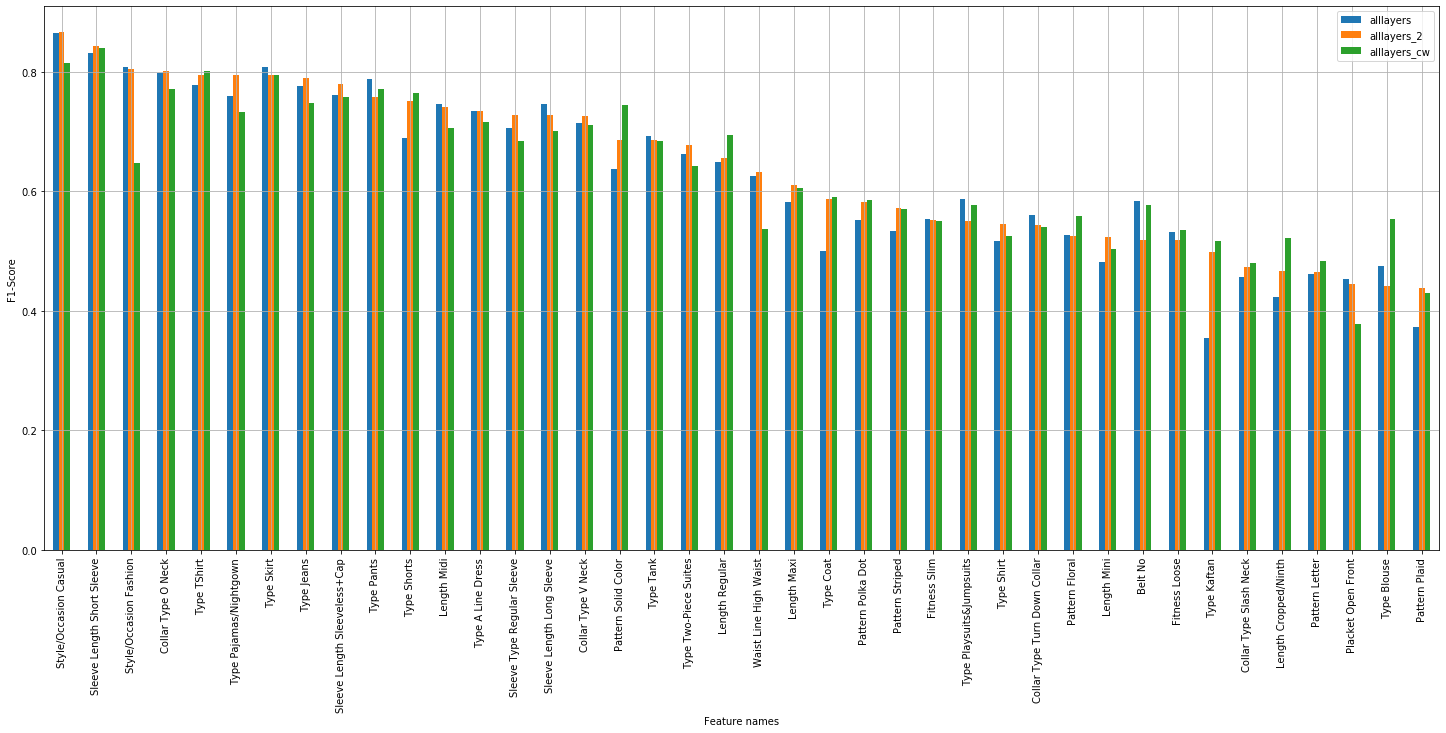

In [100]:
#f1_df.sort_values('alllayers')
f1_df.sort_values('alllayers_2', ascending=False)[['alllayers', 'alllayers_2', 'alllayers_cw']].head(40).plot(kind='bar', figsize=(25,10), grid=True)
plt.xlabel("Feature names")
plt.ylabel("F1-Score")
plt.show()

In [111]:
f1_df.head(40)

,denseonly,alllayers,classweights,alllayers_2,alllayers_cw
name,,,,,
Belt No,0.036239,0.583984,0.490430,0.519227,0.577005
Belt Yes,0.122039,0.126781,0.304958,0.174318,0.360088
Closure Type Elastic Waist,0.288889,0.401848,0.162406,0.291777,0.468240
Collar Type Halterneck,0.014925,0.309623,0.115819,0.289474,0.357895
Collar Type Hooded,0.280000,0.385417,0.121681,0.366864,0.318750
Collar Type Notched Collar,0.223529,0.274678,0.098118,0.265957,0.296000
Collar Type O Neck,0.692308,0.798058,0.670755,0.801527,0.771683
Collar Type Off Shoulder,0.035000,0.135397,0.169811,0.178947,0.225352
Collar Type Slash Neck,0.046189,0.456284,0.287739,0.473684,0.480000


In [329]:
f1_alllayers_30 = dict(list(map(lambda x: (x[0],classiutils.calculate_f1score(x[1][0], x[1][1])), presrecalls_alllayers_30.items())))
f130_df = pd.DataFrame({"name": features, "denseonly": list(f1_denseonly.values()), "alllayers": list(f1_alllayers.values()), "alllayers_30": list(f1_alllayers_30.values()), "classweights": list(f1_classweights.values())})

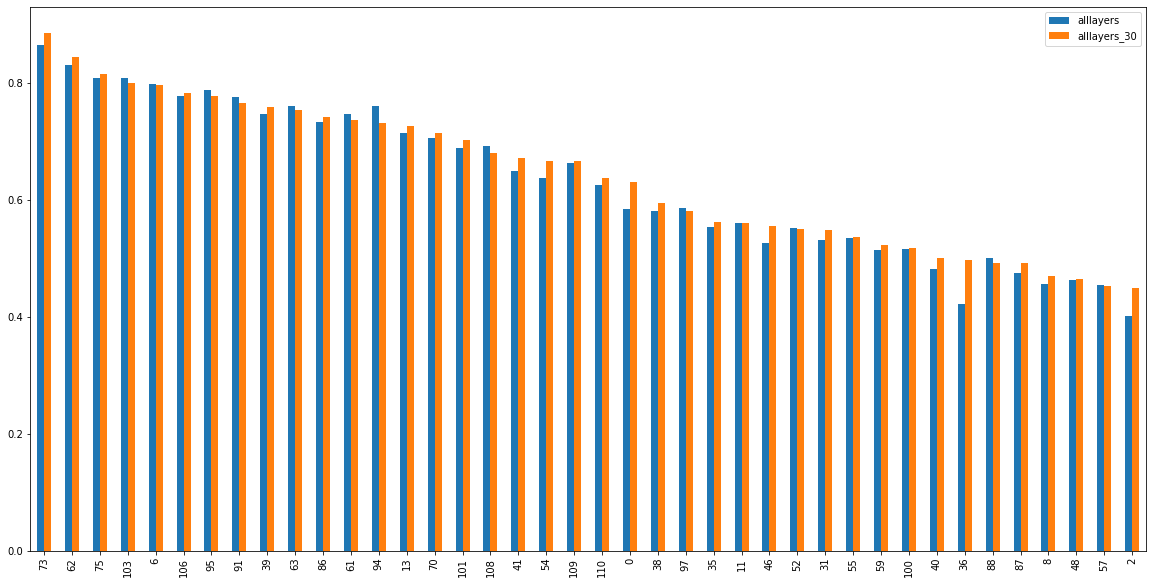

In [333]:
f130_df.sort_values('alllayers_30', ascending=False)[['alllayers','alllayers_30']].head(40).plot(kind='bar', figsize=(20,10))